In [33]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
np.random.seed(0)
tf.set_random_seed(0)

In [35]:
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [36]:
def xavier_init(fan_in, fan_out, constant=1):
    #network weights
    
    low = -constant*np.sqrt(6.0/(fan_in + fan_out))
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    
    return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32)

In [37]:
class VariationalAutoencoder(object):
    
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus,
                learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        #tf graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # create autoencoder network
        self._create_network()
        # loss function based Variational upper-bound and optimizer
        self._create_loss_optimizer()
        
        #initializing tensorflow variables
        init = tf.global_variables_initializer()
        
        #launch session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
       
    
    
    def _create_network(self):
        # Initialize autoencoder network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)
        
        # Recognition n/w to find mean and (log) variance of Gaussian 
        # distribution in latent space
        self.z_mean, self.z_log_sigma_sq = \
        self._recognition_network(network_weights["weights_recog"],
                                 network_weights["biases_recog"])
        
        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.math.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))
        
        # generator to determine mean of Bernouli distribution of reconstructed i/p
        self.x_reconstr_mean = self._generator_network(network_weights["weights_gener"],network_weights["biases_gener"])
        
        
    
    
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2' : tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean' : tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))
        }
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean':tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))
        }
        all_weights['weights_gener']={
            'h1':tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2':tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean':tf.Variable(xavier_init(n_hidden_gener_2,n_input)),
            'out_log_sigma':tf.Variable(xavier_init(n_hidden_gener_2, n_input))
        }
        all_weights['biases_gener']={
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean':tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))
        }
        return all_weights
    
    
    
    def _recognition_network(self, weights, biases):
        # generate probabilistic encoder(recognition n/w), which 
        # maps inputs onto a normal distribution in the latent space
        #The transformation is parameterized and can be learned
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']),
                                           biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),
                                          biases['b2']))
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = tf.add(tf.matmul(layer_2, weights['out_log_sigma']),
                               biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)
   


    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder n/w) , which
        # maps points in latent space onto a Bernouli distribution in data space
        # The transoformation is parameterized and can be learned
        layer_1 =  self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']),
                                           biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),
                                          biases['b2']))
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']),
                                              biases['out_mean']))
        return x_reconstr_mean

    
    
    
    def _create_loss_optimizer(self):
        # loss 1)ELBO 2) KL Divergence
        #1)ELBO
        reconstr_loss = -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean) 
                                       + (1 - self.x) 
                                       * tf.log(1e-10 + 1 - self.x_reconstr_mean), 1)
        
        #2) KL divergence
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)  # avg over batch
        
        # ADAM optimizer
        self.optimizer = \
        tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
    
    
    
    def partial_fit(self,X):
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x:X})
        return cost
    
    
    
    def transform(self, X):
        # transform data by mapping it into latent space
        return self.sess.run(self.z_mean,feed_dict={self.x : X})
    
    
    
    def generate(self, z_mu=None):
        # Generate data by sampling it into latent space
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.z: z_mu})
    
    
    
    def reconstruct(self, X):
        # use VAE to reconstruct given data
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.x: X})

In [38]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

In [39]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=75)

Epoch: 0001 cost= 176.007532293
Epoch: 0006 cost= 108.979174264
Epoch: 0011 cost= 104.462606284
Epoch: 0016 cost= 102.055481484
Epoch: 0021 cost= 100.181780728
Epoch: 0026 cost= 99.139501024
Epoch: 0031 cost= 98.306911982
Epoch: 0036 cost= 97.670944935
Epoch: 0041 cost= 97.149182115
Epoch: 0046 cost= 96.697628743
Epoch: 0051 cost= 96.296186953
Epoch: 0056 cost= 95.992583979
Epoch: 0061 cost= 95.638398118
Epoch: 0066 cost= 95.399353124
Epoch: 0071 cost= 95.150663119


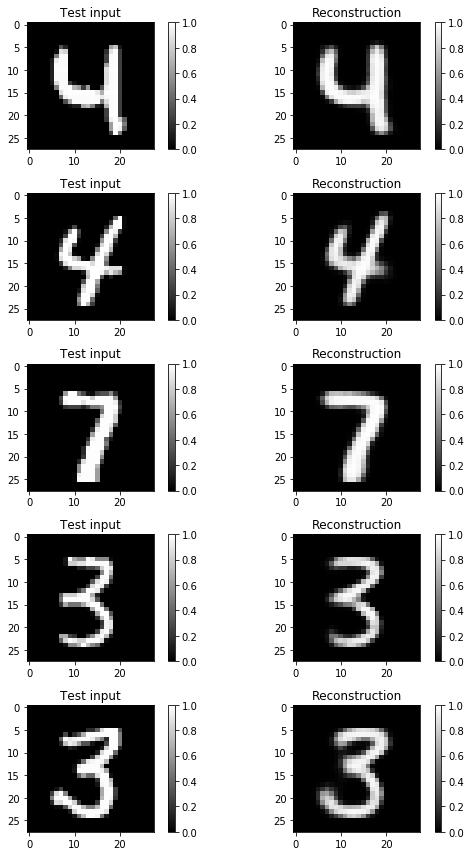

In [40]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

In [41]:
# VAE with 2d latent space
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=75)

Epoch: 0001 cost= 192.322720614
Epoch: 0006 cost= 154.604777804
Epoch: 0011 cost= 149.277033858
Epoch: 0016 cost= 146.730901600
Epoch: 0021 cost= 145.017587724
Epoch: 0026 cost= 143.760602472
Epoch: 0031 cost= 142.749807490
Epoch: 0036 cost= 141.976990773
Epoch: 0041 cost= 141.354128765
Epoch: 0046 cost= 140.781666454
Epoch: 0051 cost= 140.337065776
Epoch: 0056 cost= 139.886303364
Epoch: 0061 cost= 139.508943634
Epoch: 0066 cost= 139.269239724
Epoch: 0071 cost= 138.928590171


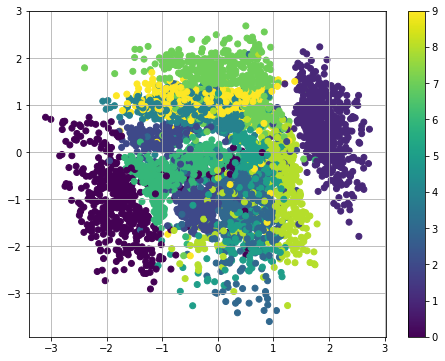

In [42]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

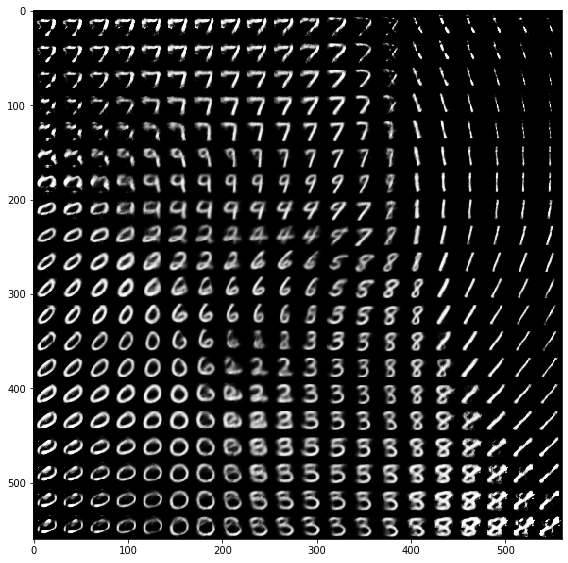

In [43]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()